# Integrantes

- Vicente Rosales
- Nicolas Fuentes

## Codigo

In [86]:
import numpy as np
import pandas as pd
import time
import tracemalloc
import matplotlib.pyplot as plt
import math

In [72]:
# ---- Header ---- #

# def evaluar_solucion(sol_bin, valores, pesos, capacidades, alpha=0.5)

# def sigmoide(x)

# def binarizar(cont)

# def sho_binario(valores, pesos, capacidades, n_hienas, max_iter, h_max=5.0, h_min=0.0, alpha)

# def leer_instancia_mkp(archivo) 

# ---- Header ---- #

def leer_instancia_mkp(archivo):
    """
    Lee una instancia de MKP desde un archivo en formato OR-Library.
    Retorna: n_items, n_dims, valores, pesos (n_items x n_dims), capacidades
    """
    with open(archivo, 'r') as f:
        lineas = f.readlines()

    idx = 0
    bloques = int(lineas[idx])  # bloques de ítems (por si se usa)
    idx += 1

    n_items, n_dims, _ = map(int, lineas[idx].split())
    idx += 1

    # Leer valores de los ítems
    valores = []
    while len(valores) < n_items:
        valores.extend(map(int, lineas[idx].split()))
        idx += 1

    # Leer pesos por dimensión
    pesos = []
    for d in range(n_dims):
        pesos_dim = []
        while len(pesos_dim) < n_items:
            pesos_dim.extend(map(int, lineas[idx].split()))
            idx += 1
        pesos.append(pesos_dim)
    pesos = np.array(pesos).T  # convertir a (n_items x n_dims)

    # Leer capacidades
    capacidades = []
    while len(capacidades) < n_dims:
        capacidades.extend(map(int, lineas[idx].split()))
        idx += 1

    return n_items, n_dims, np.array(valores), pesos, np.array(capacidades)
def sigmoide(x):
    """Función sigmoide logística."""
    return 1.0 / (1.0 + np.exp(-x))

def binarizar(cont):
    """
    Convierte un vector continuo a binario usando sigmoid + criterio probabilístico.
    cont: array de floats
    retorna: array de 0/1
    """
    prob = sigmoide(cont)
    return (np.random.rand(*cont.shape) < prob).astype(int)

def evaluar_solucion(sol_bin, valores, pesos, capacidades, alpha):
    """
    Calcula el fitness de una solución binaria para MKP con penalización.
    sol_bin: vector 0/1 de selección de ítems
    valores: vector de valores de cada ítem
    pesos: matriz (n_items x n_dims) de pesos
    capacidades: vector de capacidades por dimensión
    alpha: factor de penalización
    retorna: fitness (float), es_factible (bool)
    """
    total_valor = np.dot(sol_bin, valores)
    peso_total = pesos.T.dot(sol_bin)
    exceso = np.maximum(0, peso_total - capacidades)
    penalizacion = alpha * exceso.sum()
    fitness = total_valor - penalizacion
    factible = np.all(exceso <= 0)
    return fitness, factible

def sho_binario(valores, pesos, capacidades, n_hienas, max_iter, alpha, h_max=5.0, h_min=0.0):
    """
    Spotted Hyena Optimizer (binario) para MKP.
    Retorna:
      mejor_bin: vector binario de la mejor solución
      mejor_fitness: fitness de la mejor solución
      presa_inicial: mejor fitness en la población inicial
      mejor_presa: mejor fitness encontrado a lo largo de todas las iteraciones
      peor_presa: peor fitness encontrado a lo largo de todas las iteraciones
    """
    
    valores_hienas = []
    n_items = len(valores)
    
    # 1. Inicializar población continua en [-1,1]
    poblacion_cont = np.random.uniform(-1, 1, size=(n_hienas, n_items))
    
    # 2. Evaluar población inicial
    presa_inicial = -np.inf
    mejor_presa = -np.inf
    peor_presa =  np.inf
    mejor_bin = np.zeros(n_items, dtype=int)
    mejor_fitness = -np.inf
    mejor_cont = None
    
    for i in range(n_hienas):
        cont = poblacion_cont[i]
        binario = binarizar(cont)
        fitness, factible = evaluar_solucion(binario, valores, pesos, capacidades, alpha)
        presa_inicial = max(presa_inicial, fitness)
        mejor_presa = max(mejor_presa, fitness)
        peor_presa = min(peor_presa, fitness)
        if fitness > mejor_fitness:
            mejor_fitness = fitness
            mejor_bin = binario.copy()
            mejor_cont = cont.copy()

        if fitness not in valores_hienas:
            valores_hienas.append(fitness)
        
    # 3. Bucle de iteraciones
    for it in range(max_iter):
        # 3.1 actualizar factor de exploración/explotación
        h = h_max - (it * (h_max - h_min) / max_iter)
        
        # 3.2 evaluar cada hiena y actualizar presas
        for i in range(n_hienas):
            cont = poblacion_cont[i]
            binario = binarizar(cont)
            fitness, factible = evaluar_solucion(binario, valores, pesos, capacidades, alpha)
            mejor_presa = max(mejor_presa, fitness)
            peor_presa = min(peor_presa, fitness)
            if fitness > mejor_fitness:
                mejor_fitness = fitness
                mejor_bin = binario.copy()
                mejor_cont = cont.copy()
        
        # 3.3 mover hienas alrededor de la presa
        for i in range(n_hienas):
            if mejor_cont is None:
                break
            X = poblacion_cont[i]
            r1 = np.random.rand(n_items)
            r2 = np.random.rand(n_items)
            B = 2.0 * r1
            E = 2.0 * h * r2 - h
            D = np.abs(B * mejor_cont - X)
            poblacion_cont[i] = mejor_cont - E * D
    
    print("=========== INFO FINAL ===========")
    print("Presa inicial:", presa_inicial)
    print("Mejor presa  :", mejor_presa)
    print("Peor presa   :", peor_presa)
    print("delta        :", np.abs(mejor_presa - presa_inicial))
    print()

    return mejor_bin, mejor_fitness, presa_inicial, mejor_presa, peor_presa, factible, valores_hienas

In [73]:
# Parámetros
np.random.seed(42)  # Fijar semilla para reproducibilidad
n_items = 10       # Número de ítems
n_dims = 3         # Número de restricciones (en el fondo son las dimensiones)
n_hienas = 40      # Tamaño de la población
max_iter = 100     # Número de iteraciones

# Leer instancia fácil
n_items_faciles, n_dims_faciles, valores_faciles, pesos_faciles, capacidades_faciles = leer_instancia_mkp("Instancias/mknapcb1.txt")

# Leer instancia media
n_items_dificiles, n_dims_media, valores_media, pesos_media, capacidades_media = leer_instancia_mkp("Instancias/mknapcb5.txt")

# Leer instancia difícil
n_items_dificiles, n_dims_dificiles, valores_dificiles, pesos_dificiles, capacidades_dificiles = leer_instancia_mkp("Instancias/mknapcb9.txt")

## Pruebas

### Generales

In [74]:
results = []
instancias_txt = {
    'Fácil': 'Instancias/mknapcb1.txt',
    'Media': 'Instancias/mknapcb5.txt',
    'Difícil': 'Instancias/mknapcb9.txt',
}

# --- Parametros de la optimización --- #
n_runs = 10
n_hienas = 50
max_iter = 100
alpha = 2
# ------------------------------------- #

for nombre, archivo in instancias_txt.items():
    n_items, n_dims, valores, pesos, capacidades = leer_instancia_mkp(archivo)
    for _ in range(n_runs):
        
        # Inicializar seguimiento de tiempo y memoria
        tiempo_inicio = time.time()
        memoria_inicio = tracemalloc.start() 

        mejor_bin, mejor_valor, presa_inicial, mejor_presa, peor_presa, factible, lista_valores = sho_binario(
            valores, pesos, capacidades, n_hienas, max_iter, alpha
        )

        # Finalizar seguimiento de tiempo y memoria
        actual, peak = tracemalloc.get_traced_memory()
        tiempo_final = time.time()
        tiempo_ejecucion = tiempo_final - tiempo_inicio
        memoria_utilizada = peak / (1024 * 1024)
        tracemalloc.stop()

        # Calcular delta
        delta = mejor_valor - presa_inicial

        results.append({
            'Instancia': nombre,
            'Mejor': mejor_valor,
            'Presa inicial': presa_inicial,
            'Delta': delta,
            'Factibilidad': factible,
            'Tiempo de ejecución': tiempo_ejecucion,
            'Memoria utilizada (MB)': memoria_utilizada,
            'Valores de las presas': lista_valores
        })

# Pasar a DataFrame
df_resultados = pd.DataFrame(results)

# Faciles
df_faciles = df_resultados.loc[df_resultados['Instancia'] == 'Fácil']
df_faciles["% de mejora"] = (df_faciles["Mejor"] - df_faciles["Presa inicial"]) / np.abs(df_faciles["Presa inicial"]) * 100
df_faciles["Mean"] = df_faciles["Mejor"].mean().__round__(2)
df_faciles["Std deviation"] = df_faciles["Mejor"].std()

# Medios
df_medios = df_resultados.loc[df_resultados['Instancia'] == 'Media']
df_medios["% de mejora"] = (df_medios["Mejor"] - df_medios["Presa inicial"]) / np.abs(df_medios["Presa inicial"]) * 100
df_medios["Mean"] = df_medios["Mejor"].mean()
df_medios["Std deviation"] = df_medios["Mejor"].std()

# Dificiles
df_dificiles = df_resultados.loc[df_resultados['Instancia'] == 'Difícil']
df_dificiles["% de mejora"] = (df_dificiles["Mejor"] - df_dificiles["Presa inicial"]) / np.abs(df_dificiles["Presa inicial"]) * 100
df_dificiles["Mean"] = df_dificiles["Mejor"].mean()
df_dificiles["Std deviation"] = df_dificiles["Mejor"].std()


/tmp/ipykernel_5580/3022368624.py:55: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-x))


=========== INFO FINAL ===========
Presa inicial: -48507
Mejor presa  : 20457
Peor presa   : -166019
delta        : 68964

=========== INFO FINAL ===========
Presa inicial: -36487
Mejor presa  : 20960
Peor presa   : -156708
delta        : 57447

=========== INFO FINAL ===========
Presa inicial: -50175
Mejor presa  : 19358
Peor presa   : -160276
delta        : 69533

=========== INFO FINAL ===========
Presa inicial: -48628
Mejor presa  : 12309
Peor presa   : -163344
delta        : 60937

=========== INFO FINAL ===========
Presa inicial: -23660
Mejor presa  : 21329
Peor presa   : -178821
delta        : 44989

=========== INFO FINAL ===========
Presa inicial: -42985
Mejor presa  : 19920
Peor presa   : -155399
delta        : 62905

=========== INFO FINAL ===========
Presa inicial: -8296
Mejor presa  : -8296
Peor presa   : -165627
delta        : 0

=========== INFO FINAL ===========
Presa inicial: -16922
Mejor presa  : -4707
Peor presa   : -163347
delta        : 12215

=========== INFO FINA

/tmp/ipykernel_5580/1061496257.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_faciles["% de mejora"] = (df_faciles["Mejor"] - df_faciles["Presa inicial"]) / np.abs(df_faciles["Presa inicial"]) * 100
/tmp/ipykernel_5580/1061496257.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_faciles["Mean"] = df_faciles["Mejor"].mean().__round__(2)
/tmp/ipykernel_5580/1061496257.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

### Instancia facil

In [75]:
df_faciles

,Instancia,Mejor,Presa inicial,Delta,Factibilidad,Tiempo de ejecución,Memoria utilizada (MB),Valores de las presas,% de mejora,Mean,Std deviation
0,Fácil,20457,-48507,68964,True,1.346922,0.062750,"[-118225, -82038, -115732, -110434, -102470, -...",142.173295,13973.4,11113.895759
1,Fácil,20960,-36487,57447,False,1.324360,0.055740,"[-74831, -97039, -111472, -87921, -78406, -117...",157.445117,13973.4,11113.895759
2,Fácil,19358,-50175,69533,False,1.290933,0.055696,"[-76845, -93774, -109655, -89650, -70443, -113...",138.580967,13973.4,11113.895759
3,Fácil,12309,-48628,60937,False,1.334354,0.054740,"[-121326, -68563, -142705, -131088, -81162, -1...",125.312577,13973.4,11113.895759
4,Fácil,21329,-23660,44989,False,1.283636,0.055740,"[-108372, -95621, -120513, -110234, -116806, -...",190.147929,13973.4,11113.895759
5,Fácil,19920,-42985,62905,True,1.279902,0.052861,"[-63911, -107005, -69334, -103406, -90268, -61...",146.341747,13973.4,11113.895759
6,Fácil,-8296,-8296,0,False,1.299714,0.054694,"[-84262, -94636, -8296, -65842, -119809, -6204...",0.000000,13973.4,11113.895759
7,Fácil,-4707,-16922,12215,False,1.291176,0.055686,"[-119326, -78713, -114460, -74152, -105978, -8...",72.184139,13973.4,11113.895759
8,Fácil,19085,-41410,60495,False,1.052019,0.054520,"[-77039, -63061, -99329, -60573, -69300, -9997...",146.087901,13973.4,11113.895759
9,Fácil,19319,-16508,35827,False,0.863122,0.055696,"[-87442, -65131, -100987, -111720, -80964, -10...",217.028108,13973.4,11113.895759


### Instancia media

In [76]:
df_medios

,Instancia,Mejor,Presa inicial,Delta,Factibilidad,Tiempo de ejecución,Memoria utilizada (MB),Valores de las presas,% de mejora,Mean,Std deviation
10,Media,-286196,-286196,0,False,1.074126,0.120796,"[-286196, -578718, -463886, -563537, -574541, ...",0.000000,-33351.4,112020.247131
11,Media,-4765,-294643,289878,False,1.076563,0.122152,"[-608370, -617693, -448333, -575279, -599312, ...",98.382789,-33351.4,112020.247131
12,Media,38438,-340053,378491,False,1.106488,0.120889,"[-545406, -536915, -470656, -544290, -489724, ...",111.303532,-33351.4,112020.247131
13,Media,33669,-409654,443323,False,1.072558,0.120877,"[-419003, -431902, -499355, -566890, -480565, ...",108.218887,-33351.4,112020.247131
14,Media,44931,-300489,345420,False,0.998148,0.119705,"[-528697, -586448, -532132, -465908, -562247, ...",114.952627,-33351.4,112020.247131
15,Media,-62143,-352944,290801,False,1.069109,0.120678,"[-560343, -579388, -529929, -554286, -596625, ...",82.392958,-33351.4,112020.247131
16,Media,42559,-381484,424043,True,1.084722,0.122160,"[-517652, -433409, -559272, -522306, -490643, ...",111.156169,-33351.4,112020.247131
17,Media,-171748,-431180,259432,False,1.264177,0.121975,"[-611958, -461203, -488759, -557754, -589967, ...",60.167911,-33351.4,112020.247131
18,Media,46079,-390582,436661,False,1.325577,0.122117,"[-526203, -580314, -523268, -557163, -511861, ...",111.797523,-33351.4,112020.247131
19,Media,-14338,-406335,391997,False,1.156506,0.121081,"[-510882, -443886, -565412, -448144, -477115, ...",96.471384,-33351.4,112020.247131


### Instancia dificil

In [77]:
df_dificiles

,Instancia,Mejor,Presa inicial,Delta,Factibilidad,Tiempo de ejecución,Memoria utilizada (MB),Valores de las presas,% de mejora,Mean,Std deviation
20,Difícil,-977903,-2804337,1826434,False,1.609623,0.234199,"[-3942008, -3335628, -3839296, -3487758, -3418...",65.128906,-981190.4,731370.074292
21,Difícil,-470714,-2796850,2326136,False,1.274132,0.234247,"[-3437201, -3357905, -3475514, -3759710, -3741...",83.169852,-981190.4,731370.074292
22,Difícil,-386373,-2899629,2513256,False,1.444807,0.234672,"[-3730214, -3657246, -2968616, -3743267, -4134...",86.675088,-981190.4,731370.074292
23,Difícil,-420836,-2875098,2454262,False,1.233350,0.235385,"[-3721847, -3737635, -3713706, -3493801, -3677...",85.362725,-981190.4,731370.074292
24,Difícil,-524525,-2726854,2202329,False,1.247687,0.235624,"[-2726854, -3292636, -3772576, -3629947, -3633...",80.764463,-981190.4,731370.074292
25,Difícil,-1043516,-2825199,1781683,False,1.398046,0.235430,"[-3492271, -3635920, -3434336, -3555351, -4177...",63.063982,-981190.4,731370.074292
26,Difícil,-2437751,-2954882,517131,False,1.288240,0.233617,"[-3884606, -3461530, -3559124, -4085763, -3805...",17.500902,-981190.4,731370.074292
27,Difícil,-2140261,-2818457,678196,False,1.456899,0.234156,"[-3001248, -3336437, -3074685, -3509423, -3650...",24.062670,-981190.4,731370.074292
28,Difícil,-538087,-2878131,2340044,False,1.519220,0.235430,"[-3599456, -3872120, -3308967, -3554588, -3696...",81.304291,-981190.4,731370.074292
29,Difícil,-871938,-3035620,2163682,False,1.432773,0.233242,"[-3362975, -3834160, -3662207, -3371763, -3631...",71.276444,-981190.4,731370.074292


## Analisis grafico

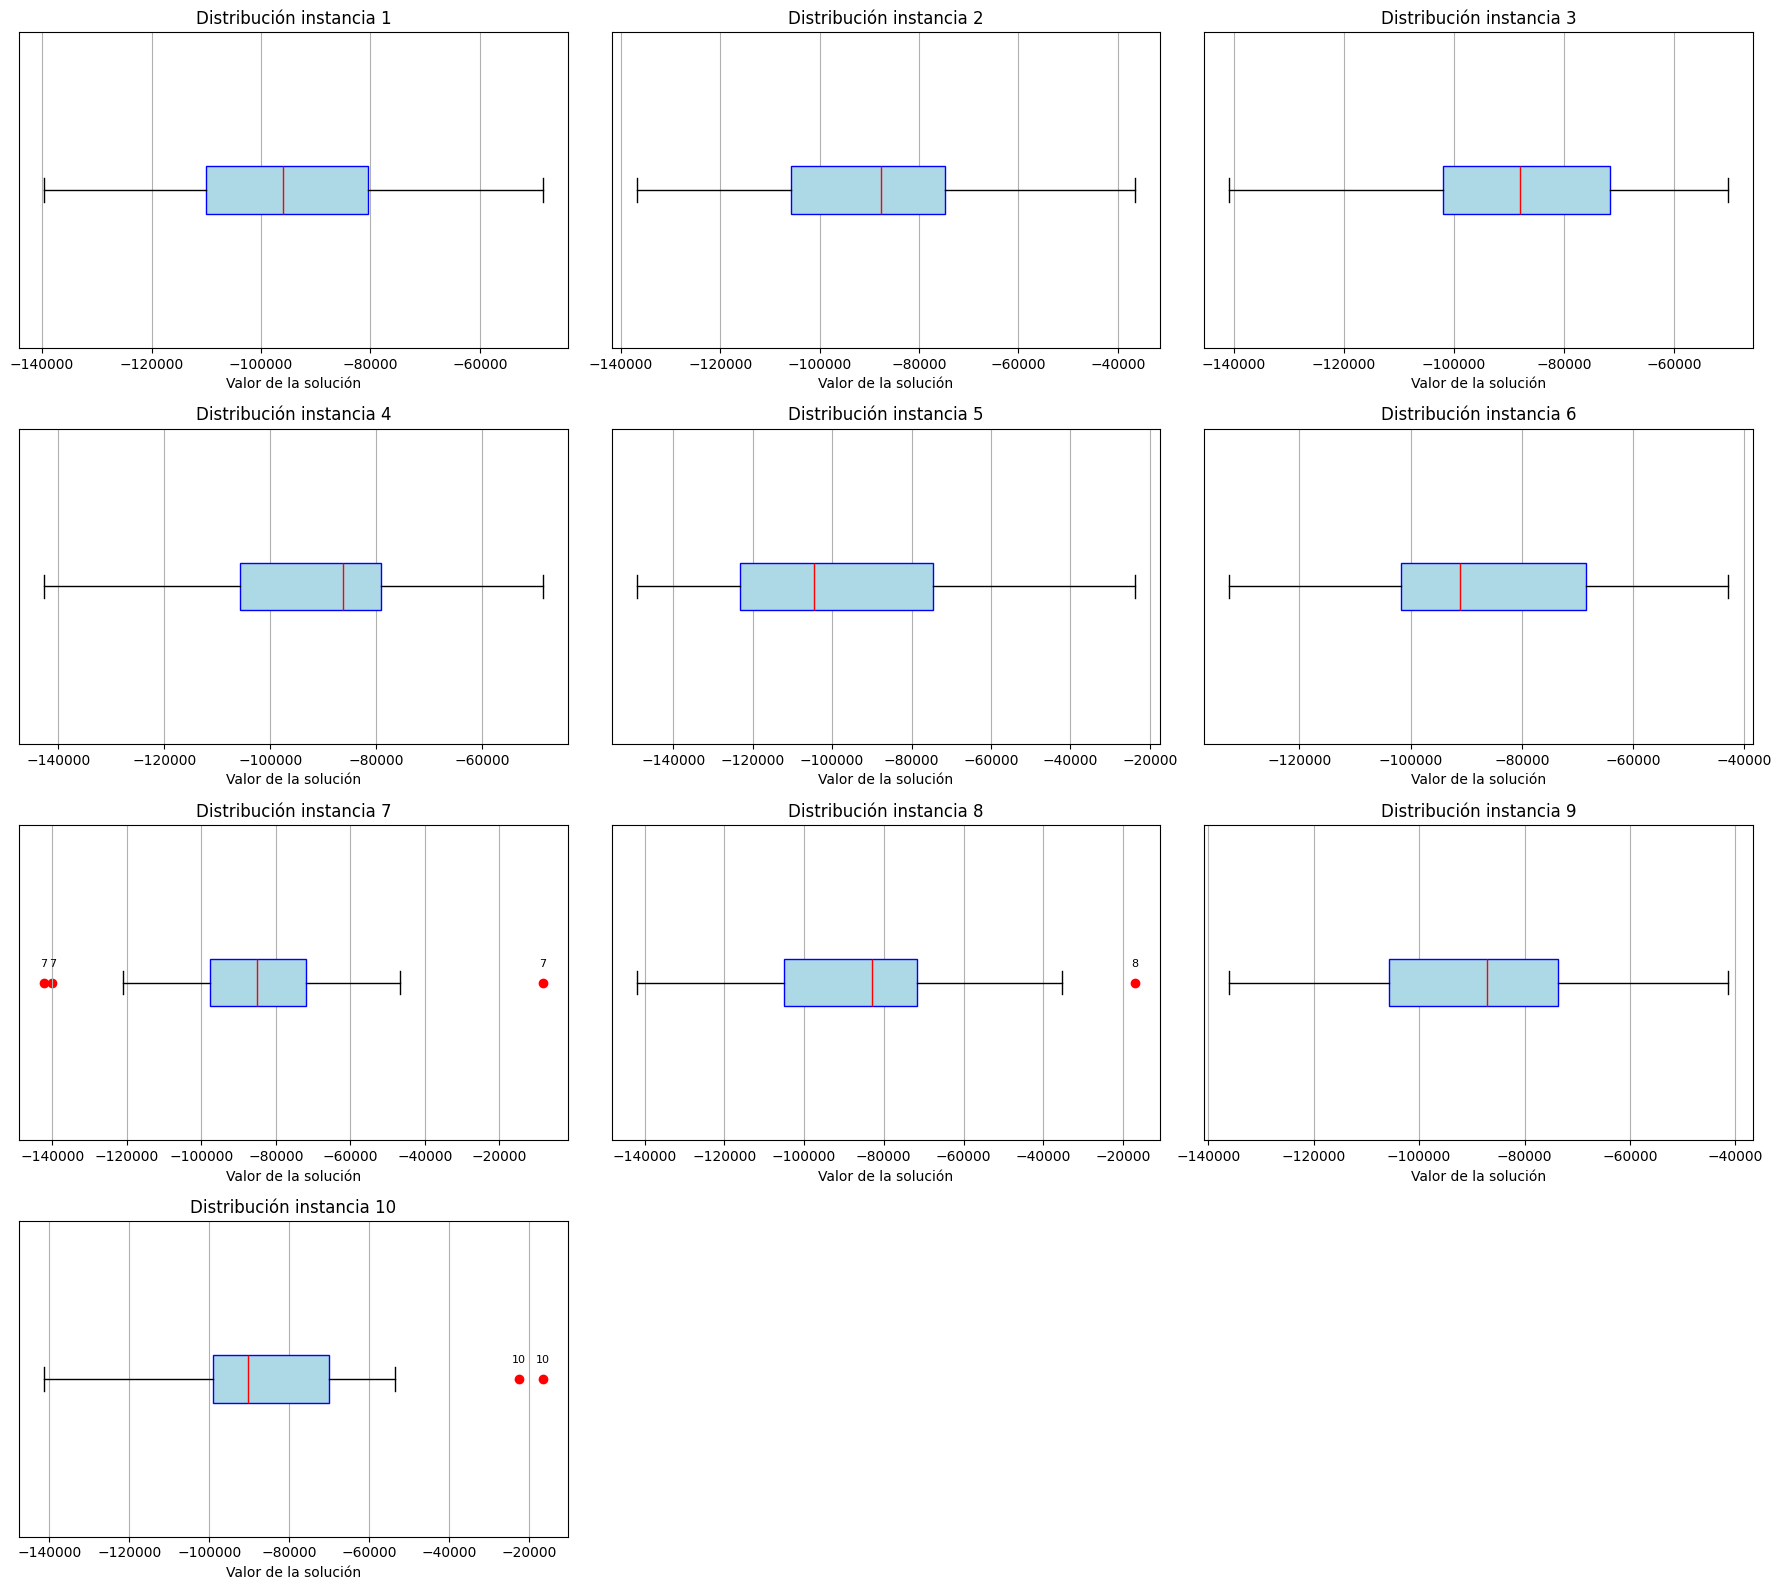

In [105]:
valores_hienas_faciles = df_faciles["Valores de las presas"]

n = len(valores_hienas_faciles)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.flatten()

for i, valores in enumerate(valores_hienas_faciles):
    # Boxplot sin mostrar outliers automáticos
    axes[i].boxplot(valores, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=dict(color='red'),
                    showfliers=False)
    
    # Calcular IQR y outliers manualmente
    q1 = np.percentile(valores, 25)
    q3 = np.percentile(valores, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = [v for v in valores if v < lower_bound or v > upper_bound]

    # Dibujar outliers con el número de instancia
    for outlier in outliers:
        axes[i].scatter(outlier, 1, color='red')
        axes[i].text(outlier, 1.05, f"{i+1}", fontsize=8, ha='center', color='black')

    axes[i].set_title(f'Distribución instancia {i+1}')
    axes[i].set_xlabel('Valor de la solución')
    axes[i].grid(True)
    axes[i].set_yticks([])

# Ocultar subplots sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


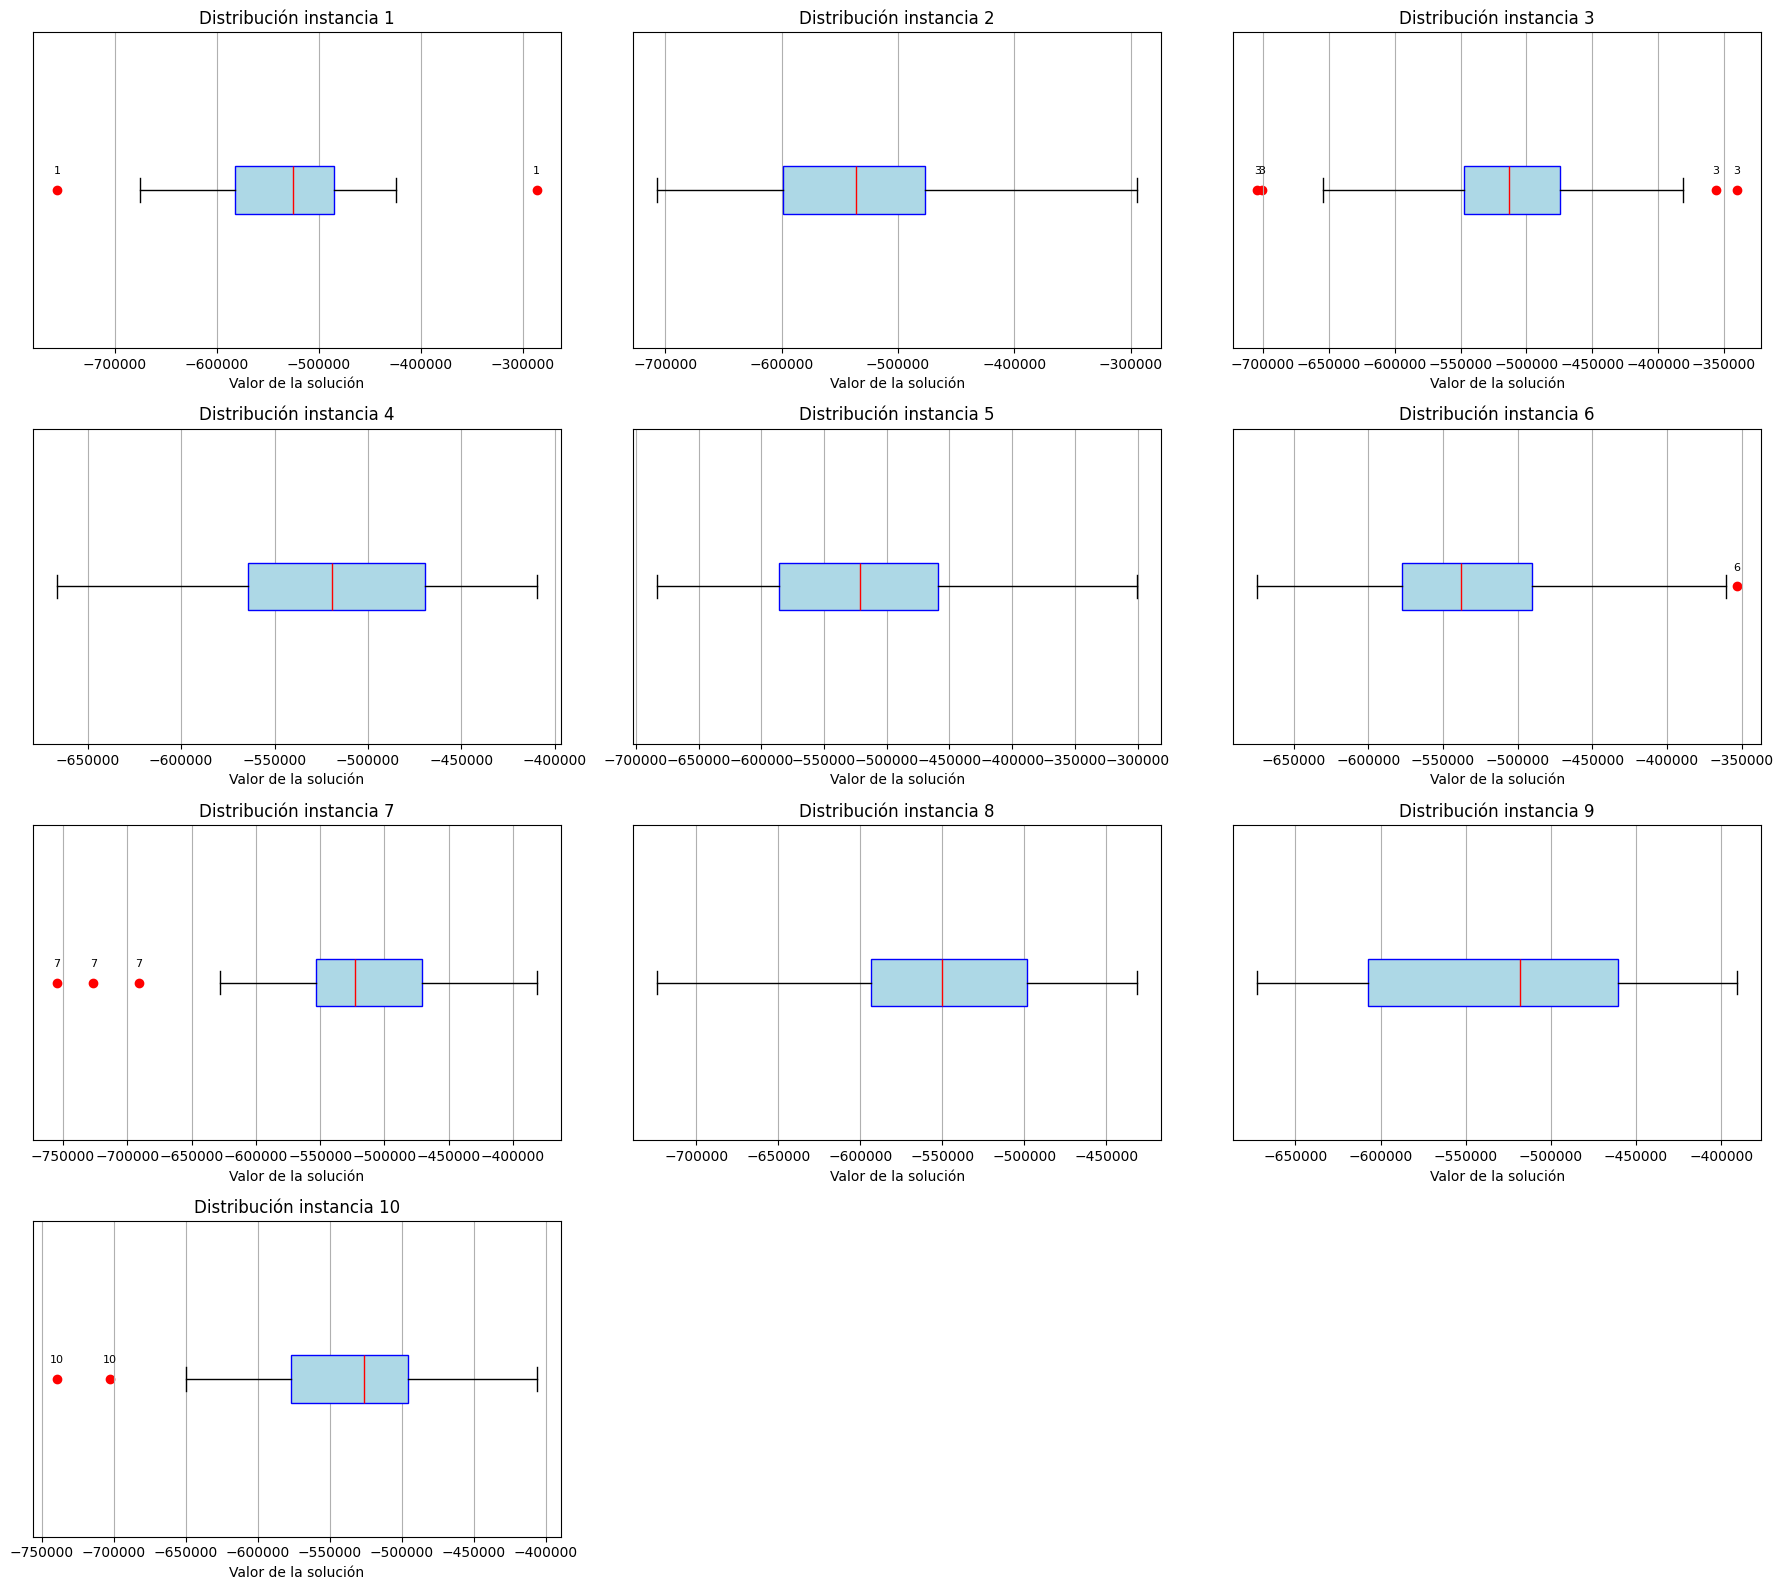

In [110]:
valores_hienas_medios = df_medios["Valores de las presas"]

n = len(valores_hienas_medios)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.flatten()

for i, valores in enumerate(valores_hienas_medios):
    # Boxplot sin mostrar outliers automáticos
    axes[i].boxplot(valores, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=dict(color='red'),
                    showfliers=False)
    
    # Calcular IQR y outliers manualmente
    q1 = np.percentile(valores, 25)
    q3 = np.percentile(valores, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = [v for v in valores if v < lower_bound or v > upper_bound]

    # Dibujar outliers con el número de instancia
    for outlier in outliers:
        axes[i].scatter(outlier, 1, color='red')
        axes[i].text(outlier, 1.05, f"{i+1}", fontsize=8, ha='center', color='black')

    axes[i].set_title(f'Distribución instancia {i+1}')
    axes[i].set_xlabel('Valor de la solución')
    axes[i].grid(True)
    axes[i].set_yticks([])

# Ocultar subplots sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


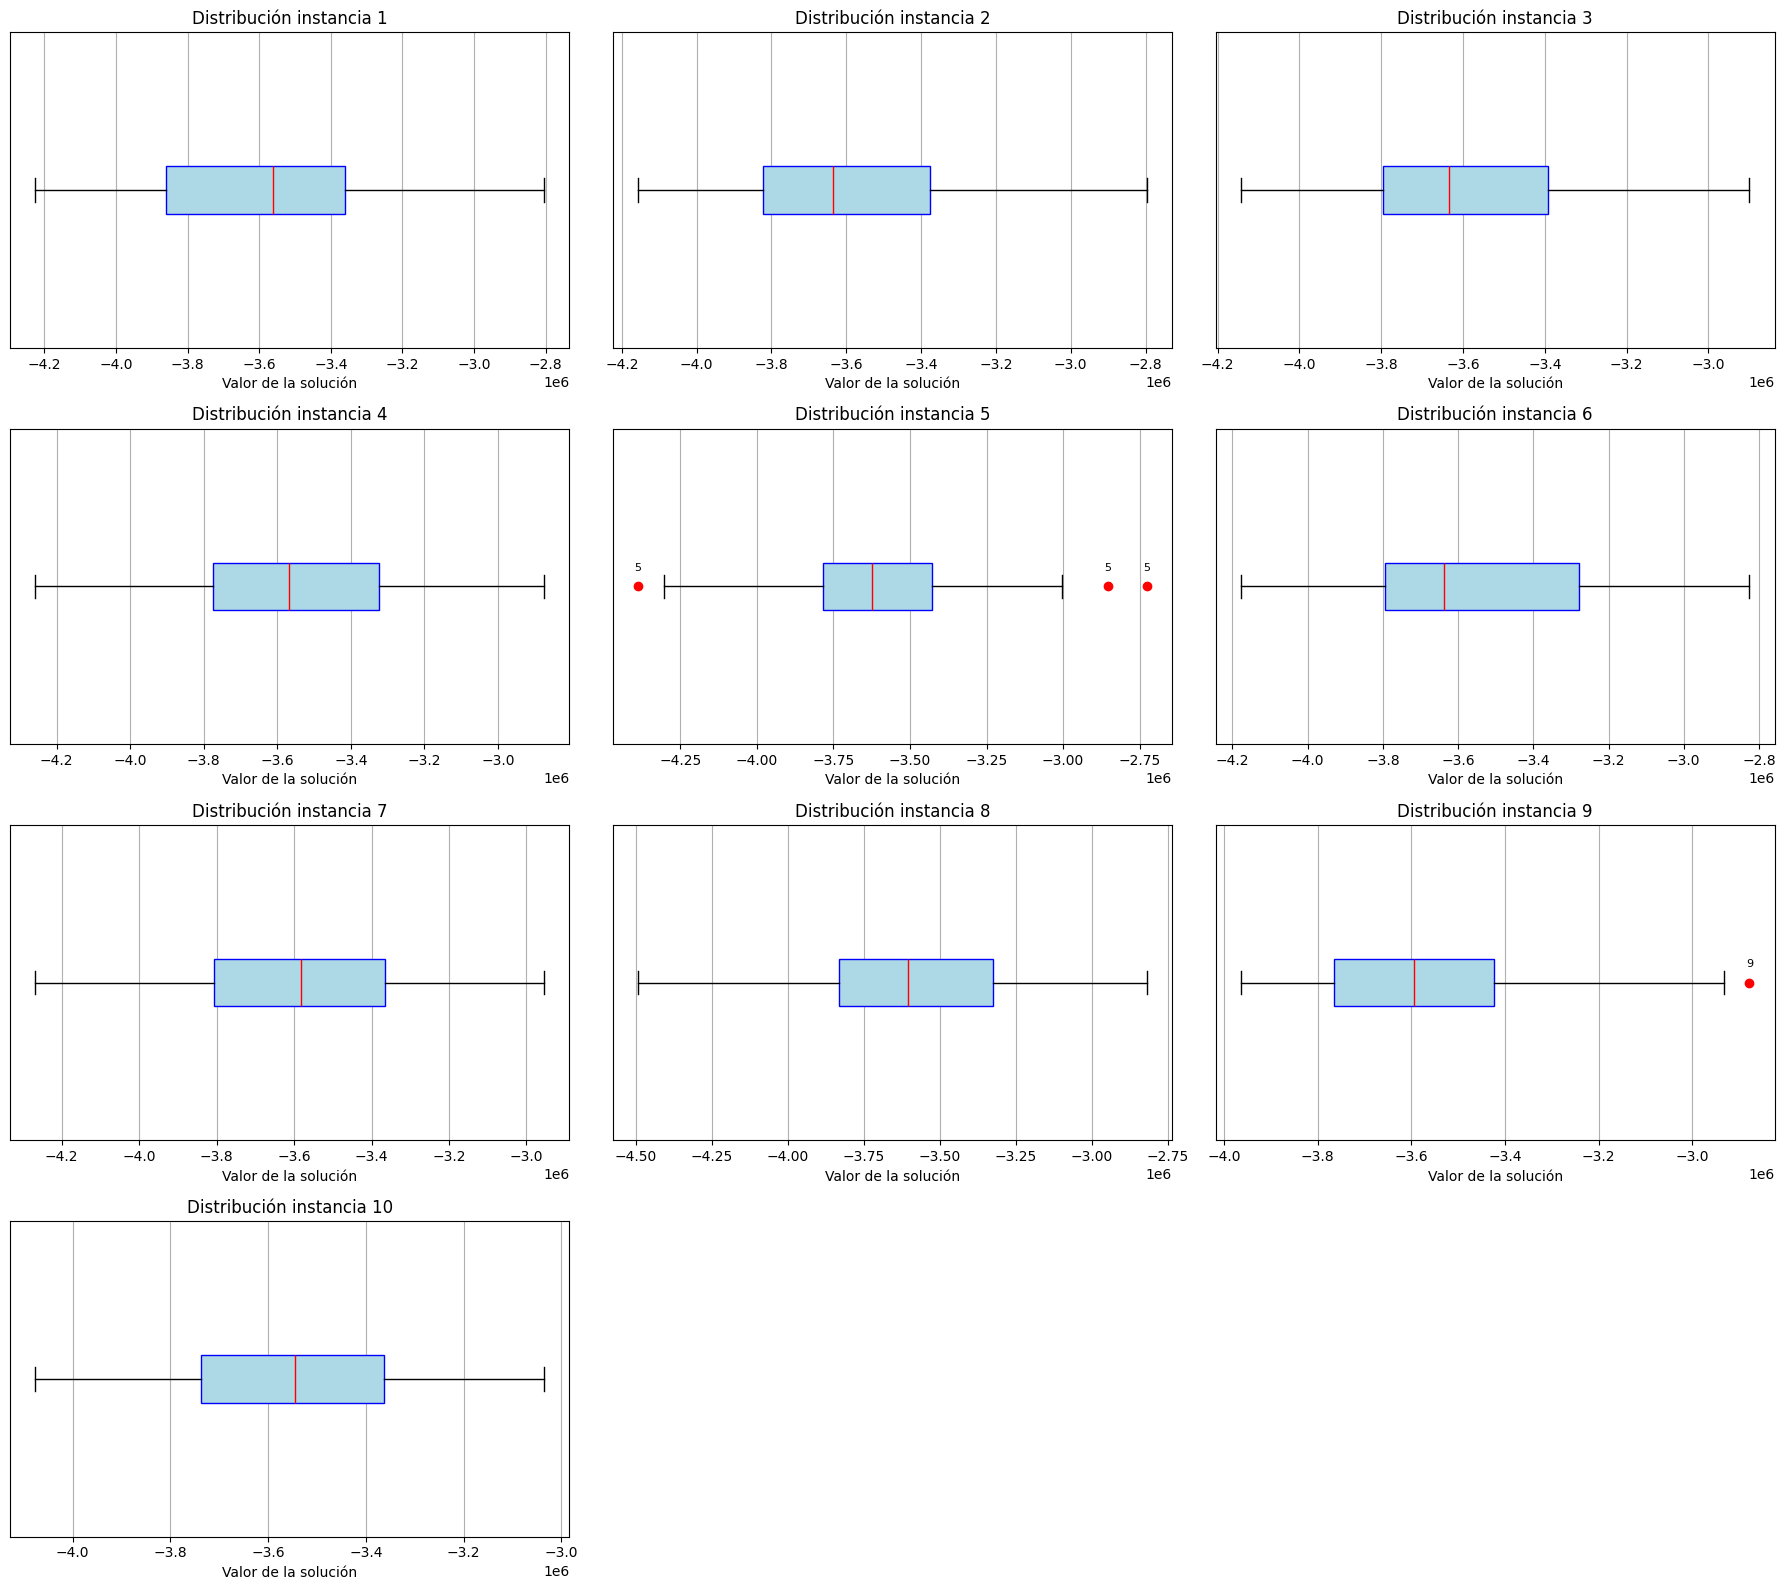

In [109]:
valores_hienas_dificiles = df_dificiles["Valores de las presas"]

n = len(valores_hienas_dificiles)
cols = 3
rows = math.ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
axes = axes.flatten()

for i, valores in enumerate(valores_hienas_dificiles):
    # Boxplot sin mostrar outliers automáticos
    axes[i].boxplot(valores, vert=False, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', color='blue'),
                    medianprops=dict(color='red'),
                    showfliers=False)
    
    # Calcular IQR y outliers manualmente
    q1 = np.percentile(valores, 25)
    q3 = np.percentile(valores, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    outliers = [v for v in valores if v < lower_bound or v > upper_bound]

    # Dibujar outliers con el número de instancia
    for outlier in outliers:
        axes[i].scatter(outlier, 1, color='red')
        axes[i].text(outlier, 1.05, f"{i+1}", fontsize=8, ha='center', color='black')

    axes[i].set_title(f'Distribución instancia {i+1}')
    axes[i].set_xlabel('Valor de la solución')
    axes[i].grid(True)
    axes[i].set_yticks([])

# Ocultar subplots sobrantes
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


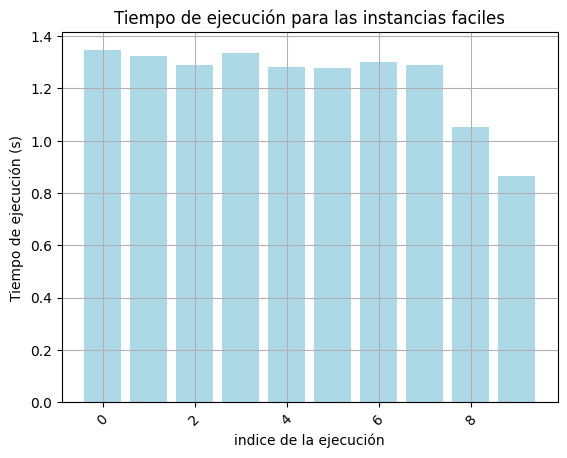

In [81]:
plt.bar(df_faciles.index, df_faciles["Tiempo de ejecución"], label='Fácil', color='lightblue')
plt.title('Tiempo de ejecución para las instancias faciles')
plt.ylabel('Tiempo de ejecución (s)')
plt.xlabel('indice de la ejecución')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

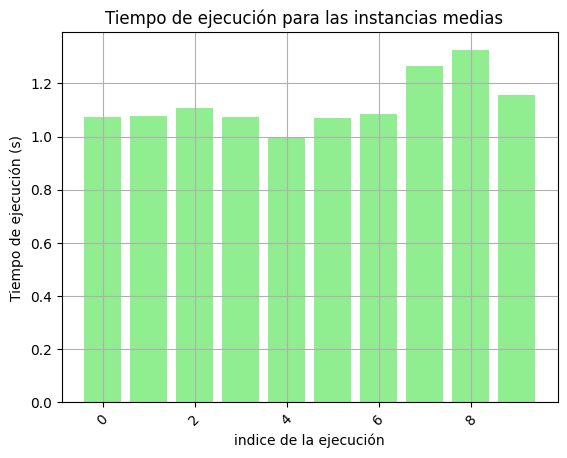

In [82]:
plt.bar(df_faciles.index, df_medios["Tiempo de ejecución"], label='Media', color='lightgreen')
plt.title('Tiempo de ejecución para las instancias medias  ')
plt.ylabel('Tiempo de ejecución (s)')
plt.xlabel('indice de la ejecución')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

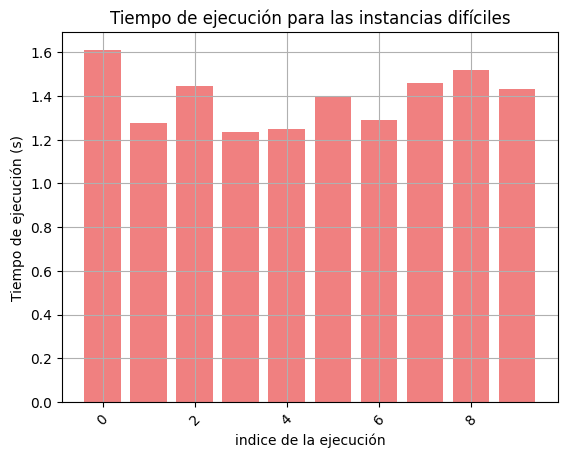

In [83]:
plt.bar(df_faciles.index, df_dificiles["Tiempo de ejecución"], label='Difícil', color='lightcoral')
plt.title('Tiempo de ejecución para las instancias difíciles')
plt.ylabel('Tiempo de ejecución (s)')
plt.xlabel('indice de la ejecución')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()